### Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from fastai import *
from fastai.vision import *
from fastai.callbacks import *

np.random.seed(42)
torch.cuda.set_device(0)

from annoy import AnnoyIndex

import glob

In [2]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)

## Creating DFs

In [3]:
#creating df of image names & dataset label (train, val, test)
img_partitions = pd.read_csv('./Eval/list_eval_partition.txt', delim_whitespace=True, header=1)

#creating df of attribute names and type label
attributes = pd.read_csv(
    './Anno/list_attr_cloth.txt', 
    sep='\s{2,}', 
    header=0, 
    skiprows=[0], 
    engine='python')

attributes_imgs = pd.read_csv(
    './Anno/list_attr_img.txt', 
    delim_whitespace=True, 
    header=0,
    skiprows=[0],
    names=(['image_name'] + attributes['attribute_name'].tolist()))
attributes_imgs.replace([-1,0,1],[False,False,True], inplace=True)

#creating df of image names, attribute tags, and dataset label
attributes_df = attributes_imgs.merge(img_partitions, how ='left', on='image_name')

In [4]:
#create list of column names to keep for training
# 1 = Texture, 2 = Fabric, 3 = Shape, 4 = Parts, 5 = Style
list_attr_names = ['image_name']+attributes[(attributes['attribute_type']==3)]['attribute_name'].tolist()
training_df = attributes_df[attributes_df['evaluation_status'].isin(['train','val'])][list_attr_names].copy()
training_df.reset_index(drop=True, inplace=True)

In [ ]:
#removing images from DF with no label
training_df['max'] = [training_df.iloc[x][1:].max() for x in training_df.index.tolist()]
training_df = training_df[training_df['max'].isin([True])].copy()
training_df.drop('max', axis=1, inplace=True)

In [ ]:
test_df = cleaned_df[cleaned_df['evaluation_status'].isin(['test'])][['image_name','category_name']].copy()
training_df['category_name'].value_counts()
test_df['category_name'].value_counts().plot()

In [6]:
def count_attr_imgs(attr_df):
    col_counts = {}

    for col in attr_df.columns[1:]:
        col_counts[col] = attr_df[col].value_counts().to_frame().loc[True][0]
    
    col_df = pd.DataFrame.from_dict(col_counts, orient='index', columns=['Count'])
    
    return col_df

#.sort_values(by='Count')

## Baseline Model (No Data Cleaning)

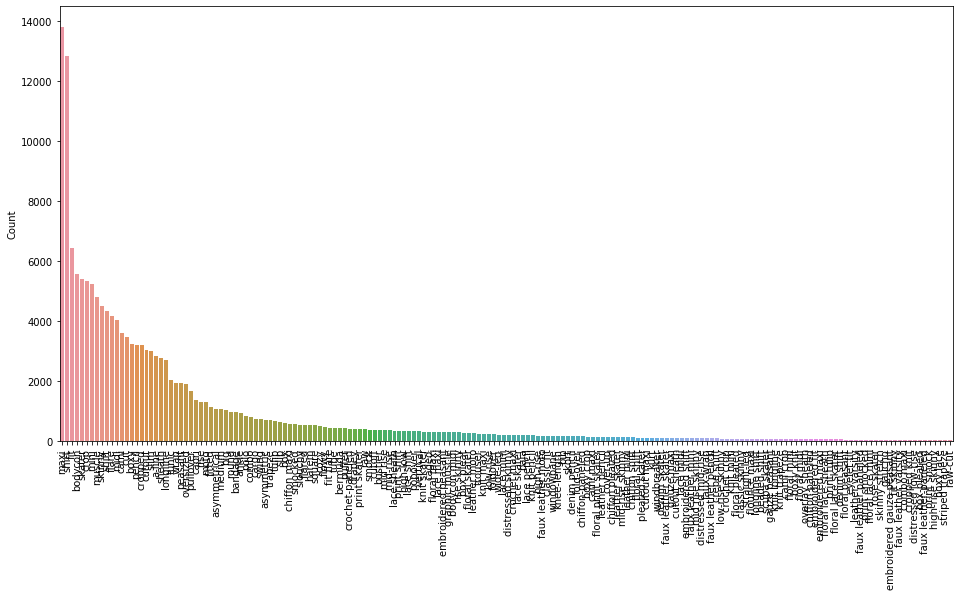

In [7]:
plt.figure(figsize=(16,8))
sns.barplot(x=count_attr_imgs(training_df).sort_values(by='Count',ascending=False).index,y=count_attr_imgs(training_df).sort_values(by='Count',ascending=False)['Count'])
plt.xticks(rotation=90);

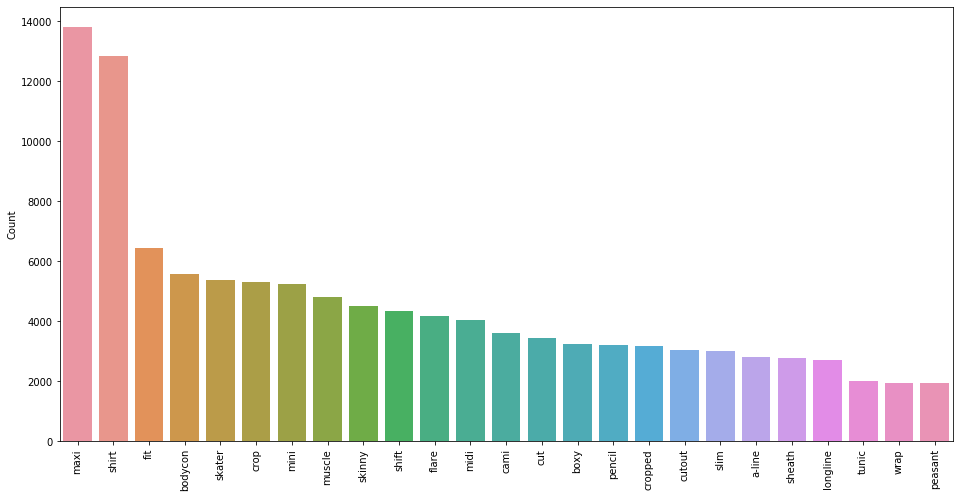

In [8]:
plt.figure(figsize=(16,8))
sns.barplot(x=count_attr_imgs(training_df).sort_values(by='Count',ascending=False)[:25].index,y=count_attr_imgs(training_df).sort_values(by='Count',ascending=False)[:25]['Count'])
plt.xticks(rotation=90);

In [9]:
from fastai import *
from fastai.vision import *

np.random.seed(42)
torch.cuda.set_device(0)

In [10]:
# take all the columns after the first "image_name" col
label_column_names = training_df.columns.tolist()[1:]

img_base_path = Path("./Img/")
data = ImageDataBunch.from_df(img_base_path, training_df, ds_tfms=get_transforms(), size=150, label_col=label_column_names)
data.normalize(imagenet_stats)

ImageDataBunch;

Train: LabelList (91242 items)
x: ImageList
Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150)
y: MultiCategoryList
fit,vertical,peasant,vertical,chiffon pleated
Path: Img;

Valid: LabelList (22810 items)
x: ImageList
Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150),Image (3, 150, 150)
y: MultiCategoryList
maxi,shirt,bodycon,cut,cutoff;mid rise;mid-rise;rise
Path: Img;

Test: None

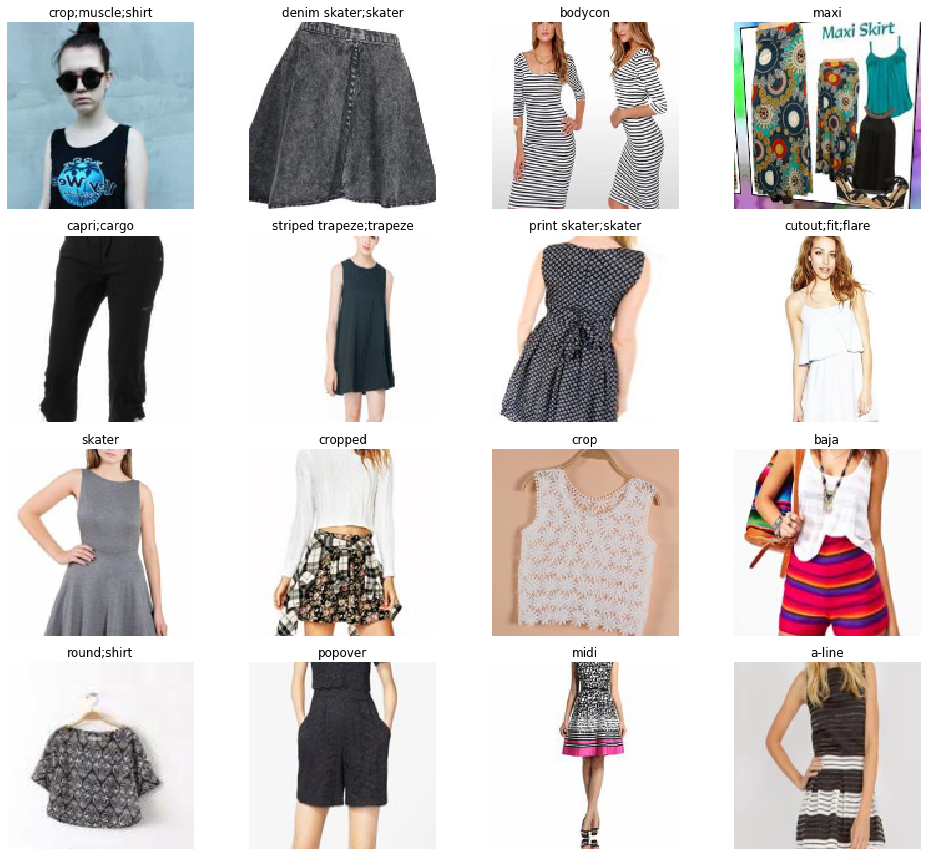

In [11]:
data.show_batch(rows=4, figsize=(14,12))

In [12]:
print(data.classes)
len(data.classes),data.c


['a-line', 'ankle', 'asymmetric', 'asymmetrical', 'baja', 'bandage', 'beaded shift', 'bermuda', 'bib', 'big', 'bodycon', 'bodycon midi', 'box', 'box pleat', 'box-pleated', 'boxy', 'boxy crop', 'boxy knit', 'boxy lace', 'bustier', 'caged', 'cami', 'cami crop', 'cami maxi', 'capri', 'cargo', 'chiffon maxi', 'chiffon paneled', 'chiffon pleated', 'chiffon shift', 'chiffon-paneled', 'classic fit', 'classic skinny', 'combo', 'combo maxi', 'cover-up', 'cozy', 'crepe shift', 'crochet crop', 'crochet maxi', 'crochet-paneled', 'crop', 'cropped', 'cropped knit', 'cut', 'cutoff', 'cutout', 'cutout maxi', 'cutout sheath', 'denim pencil', 'denim shift', 'denim skater', 'distressed low-rise', 'distressed mid-rise', 'distressed skinny', 'drapey', 'embroidered fit', 'embroidered gauze peasant', 'embroidered maxi', 'embroidered peasant', 'embroidered shift', 'eyelet fit', 'faux leather mini', 'faux leather moto', 'faux leather paneled', 'faux leather pencil', 'faux leather skater', 'faux leather varsity

(180, 180)

In [13]:
acc_03 = partial(accuracy_thresh, thresh=0.3)
f_score = partial(fbeta, thresh=0.2)

In [14]:
learn = cnn_learner(data, models.resnet50, metrics=[acc_03, f_score], callback_fns=ShowGraph)

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.031455,0.029432,0.986282,0.367765,07:40
1,0.028611,0.027188,0.987322,0.415546,07:33
2,0.027870,0.026259,0.987892,0.434561,07:35
3,0.027024,0.025699,0.987123,0.451749,07:32
4,0.026457,0.025587,0.987276,0.453395,07:30


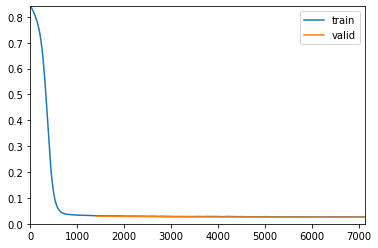

In [15]:
learn.fit_one_cycle(5)

In [16]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


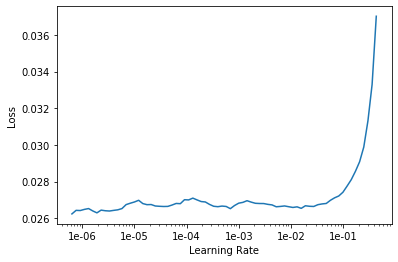

In [17]:
learn.recorder.plot()

In [18]:
learn.unfreeze()

epoch,train_loss,valid_loss,accuracy_thresh,fbeta,time
0,0.026550,0.025365,0.987183,0.461564,09:33
1,0.025790,0.024414,0.987225,0.483297,09:30
2,0.023849,0.023538,0.988539,0.504475,09:30
3,0.023268,0.023306,0.988256,0.509200,09:30


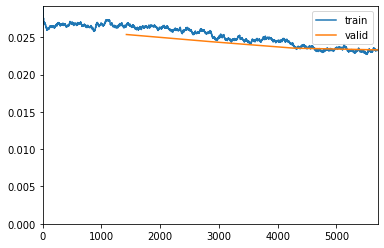

In [19]:
learn.fit_one_cycle(4, slice(1e-5,1e-3))

In [20]:
learn.save('shape-resnet50-size150-fr5-unfr4', return_path=True)
learn.export('shape-resnet50-size150-fr5-unfr4.pkl')

[('fit', 0.5990405678749084), ('slim', 0.5822779536247253), ('polo', 0.07081431895494461), ('big', 0.039424240589141846), ('fitted', 0.024753376841545105)]


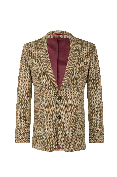

In [27]:
predict_img_path = "data/tweedeg.jpg" 
category,classIndex,losses = learn.predict(open_image(predict_img_path))
predictions = sorted(zip(data.classes, map(float, losses)), key=lambda p: p[1], reverse=True)
print (predictions[:5])
show_image(open_image(predict_img_path))


## utilising test data

In [ ]:
img_base_path = Path("Img/")
testdata = ImageDataBunch.from_df(img_base_path, test_df, ds_tfms=get_transforms(), size=224)
testdata.normalize(imagenet_stats)


learn.data = testdata

output, target = learn.get_preds(ds_type=DatasetType.Train)
top_k_accuracy(output, target, topk=(3,))

output, target = learn.get_preds(ds_type=DatasetType.Train)
top_k_accuracy(output, target, topk=(5,))